In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np

from neml2 import tensors
from neml2.postprocessing import polefigure, odf

torch.set_default_dtype(torch.float64)

In [2]:
name = "triclinic"
methods = ["coupled-implicit", "decoupled-explicit"]
nbatch = 2000
reference = "coupled-implicit"
fields = ["orientation", "elastic_strain"]
symmetry = "1"
nice_field_names = {"orientation": "Orientation", "elastic_strain": "Elastic strain"}
nice_method_names = {"coupled-implicit": "Coupled implicit", "decoupled-explicit": "Decoupled explicit", "decoupled-implicit": "Decoupled implicit"}

In [3]:
name_file = "%s_time.txt" % name
timing = {}
with open(name_file) as f:
    nsteps = list(map(int,list(filter(None,f.readline().strip().split("\t")))))
    for line in f:
        if line.strip() == "":
            continue
        raw = list(filter(None,line.strip().split("\t")))
        timing[raw[0][:-1]] = list(map(float, raw[1:]))

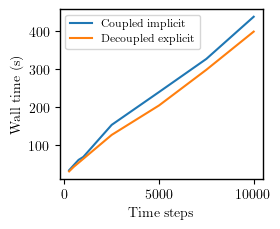

In [4]:
# Raw timing results
plt.style.use('single')
plt.figure()
for lname, data in timing.items():
    plt.plot(nsteps, data, label = nice_method_names[lname])
plt.xlabel("Time steps")
plt.ylabel("Wall time (s)")
plt.legend(loc='best', fontsize = 8)
plt.tight_layout()
plt.savefig("%s-raw-timing.pdf" % name)

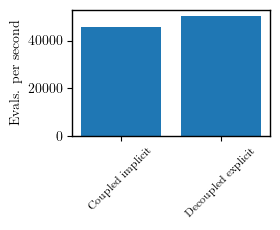

In [5]:
# Max efficiency barchart
efficiency = {k: np.max(np.array(nsteps, dtype = float) * nbatch / np.array(v)) for k,v in timing.items()}
plt.figure()
plt.bar(list(range(len(efficiency))), efficiency.values(), tick_label = [nice_method_names[k] for k in efficiency.keys()])
plt.xticks(rotation = 45, fontsize = 8)
plt.ylabel("Evals. per second")
plt.tight_layout()
plt.savefig("%s-efficiency.pdf" % name)

In [6]:
# Convergence setup
h = 1.0 / np.array(nsteps, dtype = float)
data_n = torch.load("%s-%s-%i.pt" % (name, reference,nsteps[-2]))
h_n = h[-2]
data_np1 = torch.load("%s-%s-%i.pt" % (name, reference, nsteps[-1]))
h_np1 = h[-1]
reference_fields = {field: data_np1[field][-1] - (data_np1[field][-1] - data_n[field][-1]) / (h_np1 - h_n) * h_np1 for field in fields}
combined_reference_field = torch.cat([f for f in reference_fields.values()], dim = -1)

errors = {}
for field in fields:
    errors[field] = dict()
    for method in methods:
        errors[field][method] = list()
        for n in nsteps:
            res = torch.load("%s-%s-%i.pt" % (name, method, n))[field][-1]
            errors[field][method].append(torch.mean(torch.norm(res - reference_fields[field], dim = -1)))

combined_error = {}
for method in methods:
    combined_error[method] = list()
    for n in nsteps:
        combined = torch.cat([torch.load("%s-%s-%i.pt" % (name, method, n))[field][-1] for field in fields], dim = -1)
        combined_error[method].append(torch.mean(torch.norm((combined - combined_reference_field)/combined_reference_field, dim = -1)))

/tmp/ipykernel_3044347/2452318281.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_n = torch.load("%s-%s-%i.pt" % (name, reference,nsteps[-2]))
/tmp/ipykernel_304434

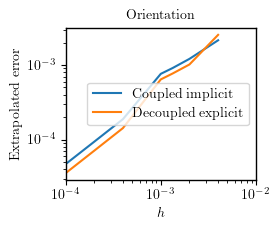

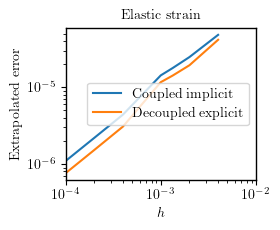

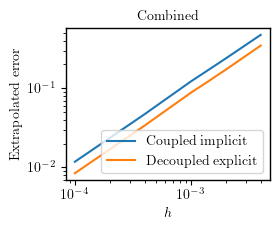

In [7]:
# Convergence plots
for field in fields:
    plt.figure()
    plt.title(nice_field_names[field])
    for method in methods:
        plt.loglog(h, errors[field][method], label = nice_method_names[method])
    plt.legend(loc='best')
    plt.xlim([1e-4,1e-2])
    plt.xlabel("$h$")
    plt.ylabel("Extrapolated error")
    plt.tight_layout()
    plt.savefig("%s-%s-convergence.pdf" % (name, field))

plt.figure()
plt.title("Combined")
for method in methods:
    plt.loglog(h, combined_error[method], label = nice_method_names[method])
plt.legend(loc='best')
plt.xlabel("$h$")
plt.ylabel("Extrapolated error")
plt.tight_layout()
plt.savefig("%s-combined-convergence.pdf" % name)

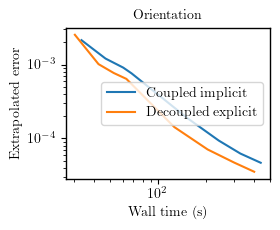

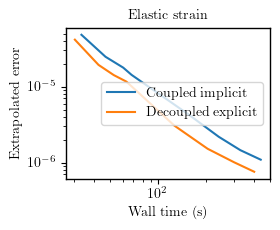

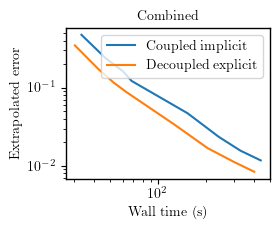

In [8]:
# Convergence plots
for field in fields:
    plt.figure()
    plt.title(nice_field_names[field])
    for method in methods:
        plt.loglog(timing[method], errors[field][method], label=nice_method_names[method])
    plt.legend(loc="best")
    plt.xlabel("Wall time (s)")
    plt.ylabel("Extrapolated error")
    plt.tight_layout()
    plt.savefig("%s-%s-accuracy.pdf" % (name, field))

plt.figure()
plt.title("Combined")
for method in methods:
    plt.loglog(timing[method], combined_error[method], label=nice_method_names[method])
plt.legend(loc="best")
plt.xlabel("Wall time (s)")
plt.ylabel("Extrapolated error")
plt.tight_layout()
plt.savefig("%s-combined-accuracy.pdf" % name)

/tmp/ipykernel_3044347/739642626.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  orients = res = torch.load("%s-%s-%i.pt" % (name, method, n))[field]


tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])


/tmp/ipykernel_3044347/739642626.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])
tensor([0.2369, 0.4786, 0.5689, 0.4786, 0.2369])


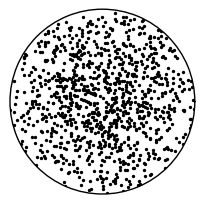

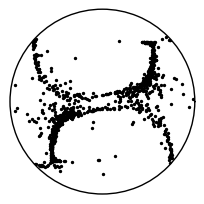

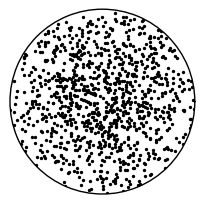

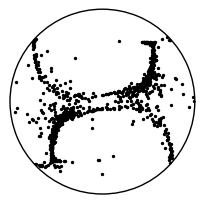

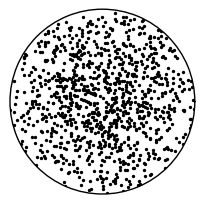

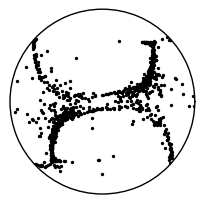

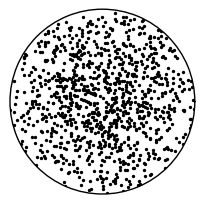

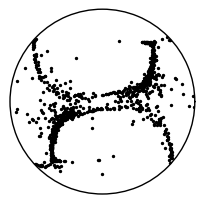

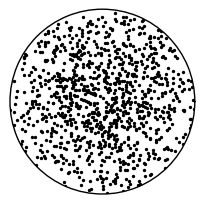

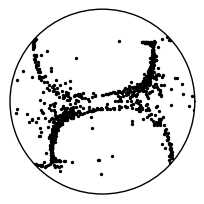

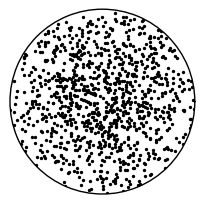

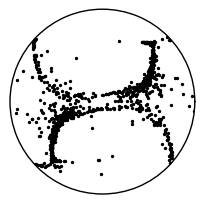

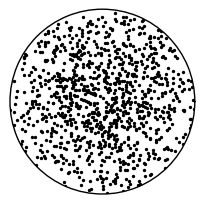

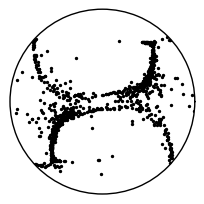

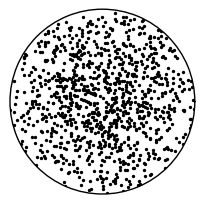

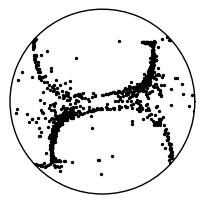

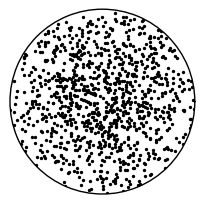

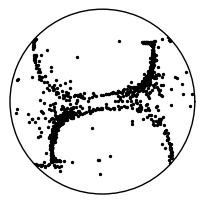

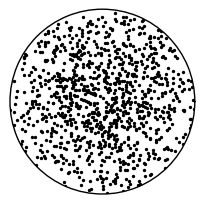

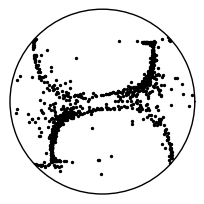

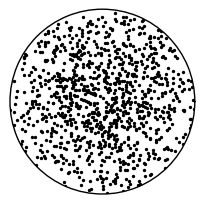

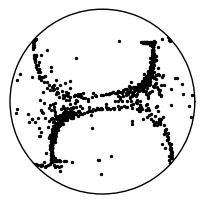

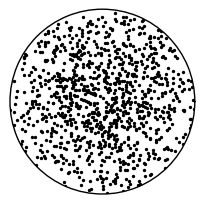

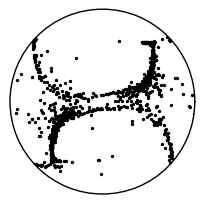

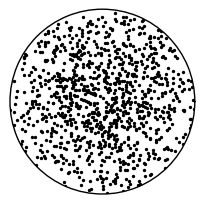

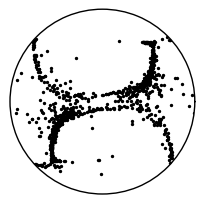

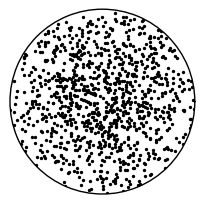

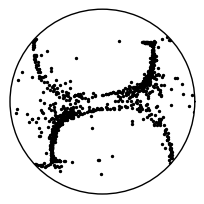

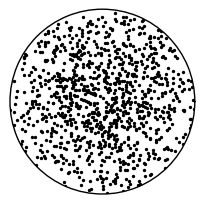

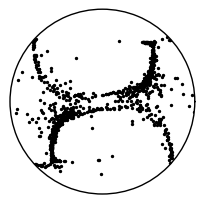

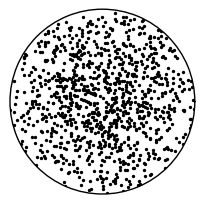

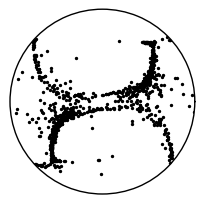

In [9]:
# Pole figures and texture index
TI = {}
field = "orientation"
for method in methods:
    TI[method] = list()
    for n in nsteps:
        orients = res = torch.load("%s-%s-%i.pt" % (name, method, n))[field]
        # [111] pole figure, initial
        plt.figure()
        polefigure.pretty_plot_polefigure(orients[0], torch.tensor([1.0,1.0,1.0]), crystal_symmetry = symmetry, point_size=2)
        plt.savefig("%s-%s-%i-111-initial.pdf" % (name,method,n))
        # [111] pole figure, final
        plt.figure()
        polefigure.pretty_plot_polefigure(
            orients[-1],
            torch.tensor([1.0, 1.0, 1.0]),
            crystal_symmetry=symmetry,
            point_size=2,
        )
        plt.savefig("%s-%s-%i-111-final.pdf" % (name, method, n))
        # Texture index for final
        dist = odf.KDEODF(tensors.Rot(orients[-1]), odf.DeLaValleePoussinKernel(torch.tensor(0.1)))
        #dist.optimize_kernel(verbose=True)
        #print(dist.kernel.h)
        TI[method].append(dist.texture_index().cpu().detach().numpy())

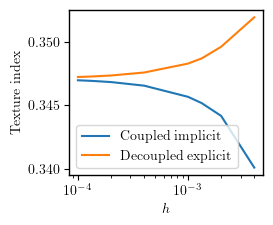

In [10]:
plt.figure()
for method in methods:
    plt.semilogx(h, TI[method], label = nice_method_names[method])
plt.xlabel("$h$")
plt.ylabel("Texture index")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("%s-TI.pdf" % name)